<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/main/Images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This project was carried out by: Michele Giambelli (5309386), Tommaso Biganzoli (5306102), Matteo delle Cave (5307468).*

# **Deep-Learning Project**
## **Image Classification with GoogLeNet**

This project focuses on image recognition using a deep learning approach, specifically employing a GoogleNet architecture. The task involves classifying food images from a reduced version of the well-known Food-101 dataset. The dataset has been downsized to include only 12 distinct classes, each representing a specific category of food. The goal is to accurately classify images into these categories, leveraging the efficiency and performance of GoogleNet for this multi-class classification problem.

*At first we install all the necessary dependencies*

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [ ]:
from d2l import torch as d2l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset path
dataset_path = '/content/drive/MyDrive/food_12_small'

In [ ]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## **DEA**

In this section we want to show the distribution of the images dimensions, in order to have a clearer idea of our dataset.

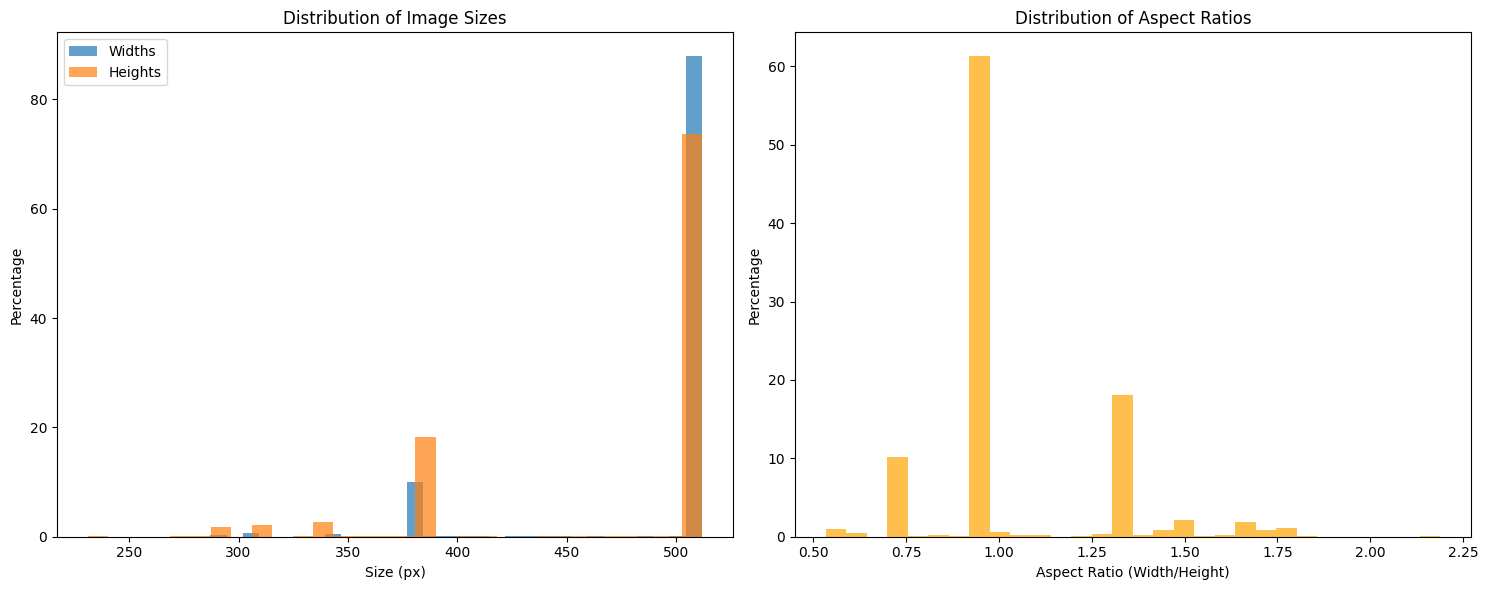

In [ ]:
# Extract image dimensions
image_sizes = []

for root, _, files in os.walk(dataset_path):  # Traverse folders and subfolders of dataset_path
    for image_name in files:
        if image_name.endswith('.jpg'):
            image_path = os.path.join(root, image_name)  # Full path to the image
            with Image.open(image_path) as img:
                image_sizes.append(img.size)  # (width, height)

# Analyze widths, heights, and aspect ratios
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]
aspect_ratios = [w / h for w, h in zip(widths, heights)]

# Distribution of dimensions (width, height)
width_counts, width_bins = np.histogram(widths, bins=30)
height_counts, height_bins = np.histogram(heights, bins=30)
width_percent = (width_counts / len(widths)) * 100
height_percent = (height_counts / len(heights)) * 100

# Distribution of aspect ratios
aspect_counts, aspect_bins = np.histogram(aspect_ratios, bins=30)
aspect_percent = (aspect_counts / len(aspect_ratios)) * 100

# Plot distributions
plt.figure(figsize=(15, 6))

# Plot 1: Distribution of dimensions
plt.subplot(1, 2, 1)
plt.bar(width_bins[:-1], width_percent, width=np.diff(width_bins)[0], alpha=0.7, label='Widths', align='edge')
plt.bar(height_bins[:-1], height_percent, width=np.diff(height_bins)[0], alpha=0.7, label='Heights', align='edge')
plt.title('Distribution of Image Sizes')
plt.xlabel('Size (px)')
plt.ylabel('Percentage')
plt.legend()

# Plot 2: Distribution of aspect ratios
plt.subplot(1, 2, 2)
plt.bar(aspect_bins[:-1], aspect_percent, width=np.diff(aspect_bins)[0], alpha=0.7, color='orange')
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()


The first histogram illustrates the distribution of image sizes (widths and heights), showing that the majority of images have dimensions close to 500 pixels. Resizing these images to \(224 x 224\) pixels for GoogleNet significantly reduces their size, which is necessary for uniform input to the neural network but might lead to some loss of visual detail. This resizing is crucial for compatibility with the network's architecture.

The second histogram presents the distribution of aspect ratios (width/height) of the images. The peak around 1.0 indicates that most images in the dataset are nearly square. However, there are noticeable variations, with some images having wider or taller proportions. When resizing these images to a fixed square shape \(224 x 224\), non-square images may experience distortion or cropping, depending on the preprocessing strategy. Managing this variability is important to ensure that meaningful features are preserved across different aspect ratios.

**Now let's plot a Pie Chart to see the distribution of the labels**

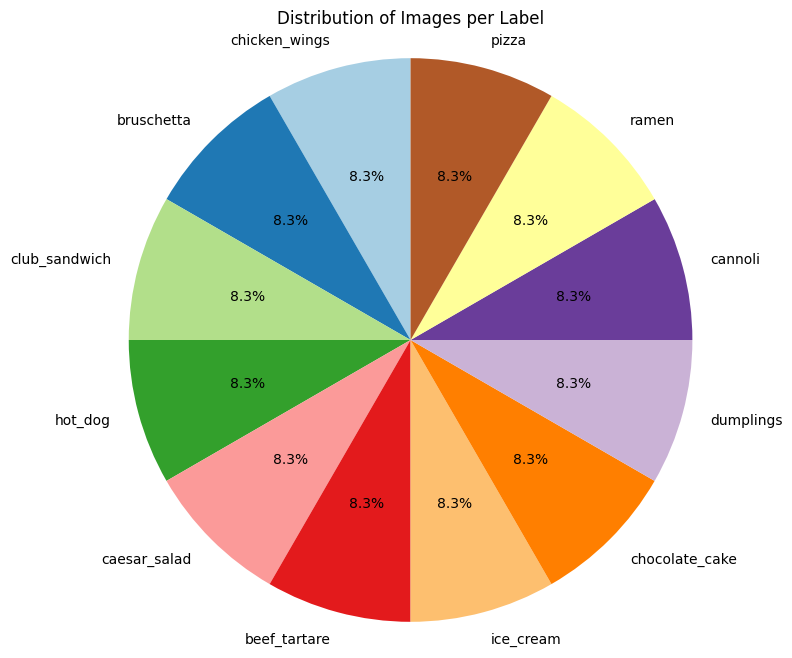

In [ ]:
# Get the count of images in each label (subfolder)
label_counts = {}

# Traverse the dataset_path to count images in each subfolder
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Ensure it's a folder
        num_images = len([file for file in os.listdir(label_path) if file.endswith('.jpg')])
        label_counts[label] = num_images

# Check if there are any labels
if not label_counts:
    raise ValueError("No labels found in the dataset path.")

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Paired.colors)  # Use different colors for better distinction
plt.title('Distribution of Images per Label')
plt.axis('equal')  # Ensure pie is drawn as a circle
plt.show()


As we can see from the pie chart above the labels are perfeclty balanced.

**Visualizing Random Images from Subfolder-Based Categories**

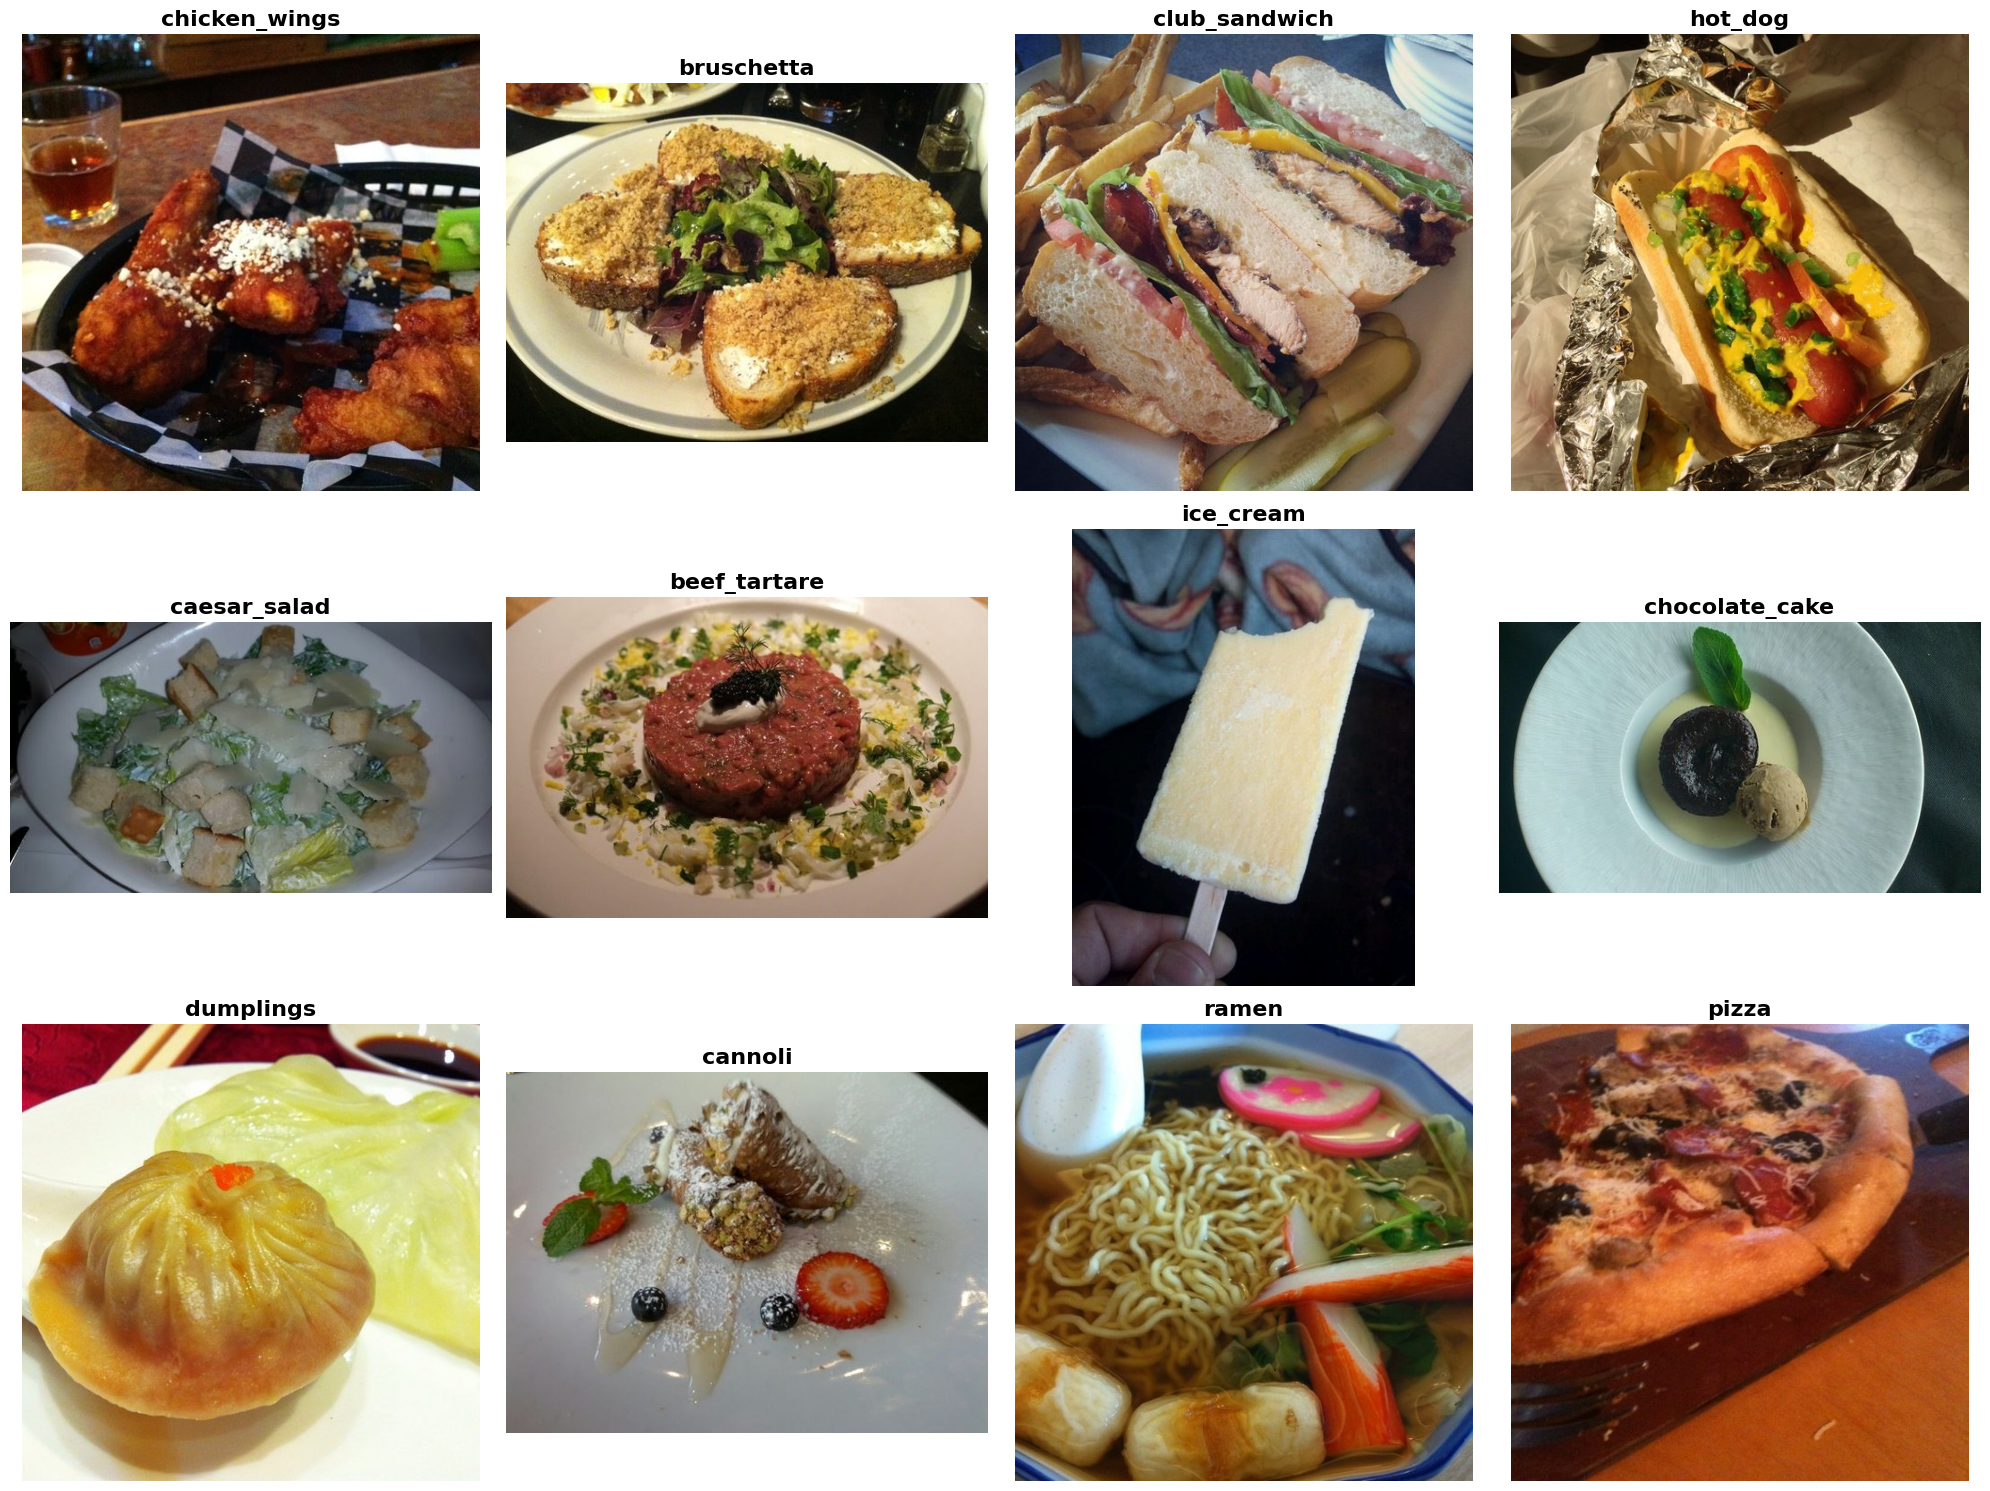

In [ ]:
# Create a dictionary with images for each category (subfolder)
category_to_images = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Ensure it's a folder
        category_to_images[label] = [file for file in os.listdir(label_path) if file.endswith('.jpg')]

# Check if there are any categories
if not category_to_images:
    raise ValueError("No categories found in the dataset path.")

# Set a seed for reproducibility
random.seed(123)

# Select a random image for each category
random_images = {}
for category, images in category_to_images.items():
    if images:  # Ensure there are images for the category
        random_images[category] = random.choice(images)

# Set up the plots
num_categories = len(random_images)
rows = (num_categories + 3) // 4  # Dynamically calculate the number of rows for the plot
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

for ax, (category, image_name) in zip(axes, random_images.items()):
    image_path = os.path.join(dataset_path, category, image_name)
    try:
        with Image.open(image_path) as img:
            ax.imshow(img)
            ax.set_title(category, fontsize=16, fontweight='bold')
            ax.axis('off')  # Hide axes for a cleaner look
    except FileNotFoundError:
        ax.set_title(f"Missing: {category}", fontsize=16, fontweight='bold')
        ax.axis('off')  # Hide axes for missing images

# Hide unused axes
for ax in axes[len(random_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## **Load the dataset**







The code below defines a data loading pipeline for image datasets using [PyTorch Data Loader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), including functions for parallel data loading and optional data augmentation.

1. **`get_dataloader_workers`**:  
   - Returns the number of CPU cores to optimize parallel data reading.
   - Allows efficient data loading by leveraging multiprocessing.

2. **`data_loader`**:
   - **Purpose**: Prepares the dataset, splits it into training, validation, and test subsets, and creates `DataLoader` objects for batch processing.
   - **Key Steps**:
     - **Normalization Check**: Requires `mean` and `std` for dataset normalization.
     - **Transformations**:
       - Resizing, tensor conversion, and normalization are applied to all datasets.
       - Optional data augmentation (e.g., rotation, flipping, cropping) is applied only to the training dataset for improved model generalization.
     - **Dataset Loading**:
       - Uses `ImageFolder` to load the dataset and `random_split` to divide it into training, validation, and test subsets based on specified percentages. For that reason we organize our dataset in sub-folders, each containing images for several labels.
     - **Data Loaders**:
       - Creates `DataLoader` objects for each dataset subset with appropriate batch sizes, shuffling, and multiprocessing support.

3. **Customizability**:
   - Includes adjustable parameters such as image size (`height`, `width`), batch size, dataset splitting percentages, and random seed for reproducibility.

4. **Efficiency**:
   - Leverages CPU cores for parallelism and minimizes overhead by applying augmentations only to training data.

5. **Output**:
   - Returns the dataset and `DataLoader` objects for training, validation, and testing, ready for use in our model.

In [ ]:
def get_dataloader_workers():
    import os
    return os.cpu_count()

def data_loader(dataset_path,
                batch_size,
                height, width,
                augmentation = False,
                train_perc=0.7, val_perc=0.2,
                seed=123,
                mean=None, std=None):

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Verify that mean and std are given
    if mean is None or std is None:
        raise ValueError("Mean and Std must be provided for normalization.")

    trans = transforms.Compose([
        transforms.Resize((height, width)),       # Resize to (height, width)
        transforms.ToTensor(),                    # Converts to tensor
        transforms.Normalize(mean=mean, std=std)  # Normalization
    ])

    # Upload dataset with ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=trans)

    # Compute splitting size
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Apply augmentation only to the training dataset
    if augmentation:
        data_augmentation = transforms.Compose([
            transforms.Resize((height, width)),       # Resize a (height, width)

            # Data Augmentation
            transforms.RandomApply([transforms.RandomRotation(degrees=20)], p=0.5),
            transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),

            transforms.ToTensor(),                    # Converts to tensor
            transforms.Normalize(mean=mean, std=std)  # Normalization
        ])

        train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=data_augmentation)

    # Creazione dei DataLoader
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return dataset, train_loader, val_loader, test_loader

#### **Then we want to visualize the first half-batch of images**

- **`mean` and `std`**: These values are the channel-wise means and standard deviations for the RGB channels, computed from the dataset. They are used to normalize the input images, ensuring each channel has zero mean and unit variance, which helps in stabilizing and speeding up the training process.

- **`batch_size = 64`**: A moderately large batch size is chosen to strike a balance between training speed and memory efficiency, making it suitable for most GPUs.

- **`augmentation = True`**: Data augmentation is enabled to increase the diversity of training samples, improving the model's generalization and robustness.

- **`height = 224` and `width = 224`**: The input image dimensions are resized to 224 X 224, which is the standard input size required by many deep learning architectures, including GoogleNet.



In [ ]:
mean = [0.5437, 0.4453, 0.3496]
std = [0.2687, 0.2710, 0.2731]

dataset, train_loader, val_loader, test_loader = data_loader(dataset_path = dataset_path,
                                                             batch_size = 64,
                                                             height = 224, width = 224,
                                                             augmentation = True,
                                                             mean = mean, std = std)

We then build up a dictionary to map all the labels to an id

In [ ]:
# Labels dictionary
class_to_idx = dataset.class_to_idx
class_to_idx

{'beef_tartare': 0,
 'bruschetta': 1,
 'caesar_salad': 2,
 'cannoli': 3,
 'chicken_wings': 4,
 'chocolate_cake': 5,
 'club_sandwich': 6,
 'dumplings': 7,
 'hot_dog': 8,
 'ice_cream': 9,
 'pizza': 10,
 'ramen': 11}

###**Visualize the first half batch of images**

This is how will look like the input of our net, and we can easily see the differences between the raw images plotted above. This is due to to the fact that we perform a lot of trasformations in the dataset loading settings above

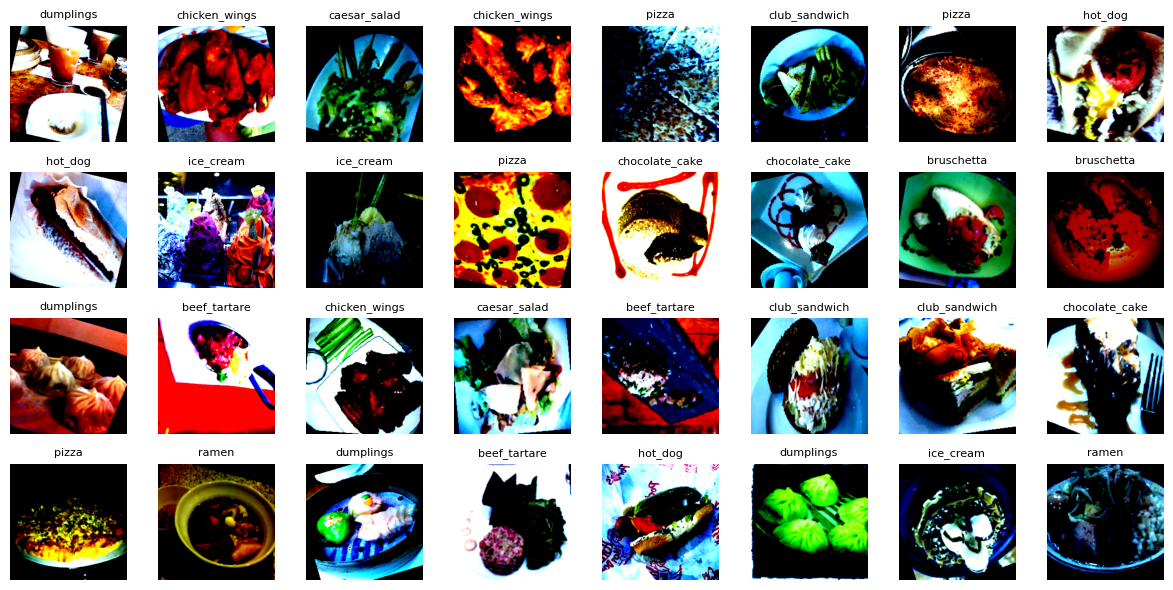

In [ ]:
def id2label(labels, class_to_idx):
    """Return text labels from the corresponding numeric labels in the Fashion-MNIST dataset."""
    text_labels = list(class_to_idx.keys())
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    Plot a list of images.

    Args:
        imgs: List or tensor of images to display.
        num_rows: Number of rows in the plot grid.
        num_cols: Number of columns in the plot grid.
        titles: Titles for each image (optional).
        scale: Scaling factor for the figure size.
    """
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Convert tensor image to NumPy and permute for matplotlib compatibility
            ax.imshow(img.permute(1, 2, 0).numpy())
        else:
            # Assume PIL image
            ax.imshow(img)
        ax.axis('off')  # Hide axis
        if titles:
            ax.set_title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()


# Ottieni un batch dal train_loader
X, y = next(iter(train_loader))

# Converto le etichette numeriche in testo (se hai il mapping class_to_idx)
text_labels = id2label(y, class_to_idx)

# Visualizzo le immagini
show_images(X, 4, 8, titles=text_labels)

# **GoogLeNet**


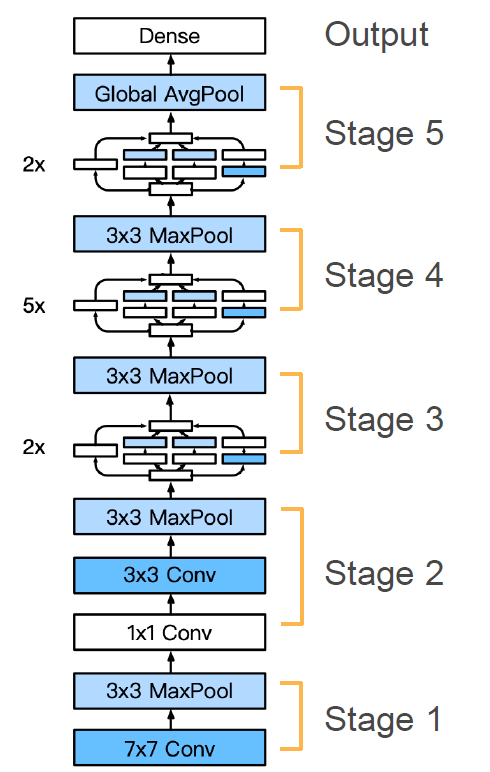

Inception blocks are the core of GoogleNet, designed to process features at multiple scales while keeping computational costs low. Each block has four parallel paths:

1×1 convolutions for dimensionality reduction,
1
×
1
→
3
×
3
1×1→3×3 and
1
×
1
→
5
×
5
1×1→5×5 convolutions for capturing medium and large-scale patterns, and max pooling followed by
1
×
1
1×1 convolutions to extract robust features.

Initially, we faced significant vanishing gradient problems, as shown in the slides. To address this, we introduced Batch Normalization to stabilize activations, Leaky ReLU to maintain gradient flow for negative inputs, and a gradual dropout strategy to reduce overfitting. These adjustments made the blocks more stable during training and improved overall performance.

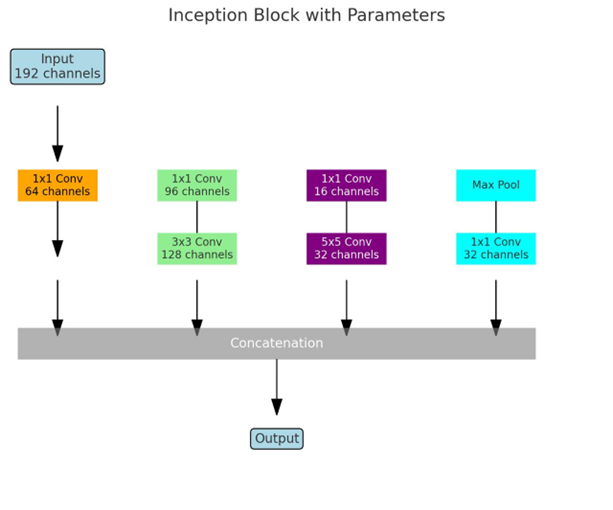

### **Inception Blocks**

In [ ]:
class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)

        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        #Path 2: 1x1 -> 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),  # BatchNorm
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),  # BatchNorm
        )

        # Path 3: 1x1 -> 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),  # BatchNorm
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),  # BatchNorm
        )

        # Path 4: Max Pooling -> 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),  # BatchNorm
        )

    def forward(self, x):
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)

        return output


## **Blocks**


#### *Below we implement the code to define the blocks of our custom GoogLeNet as:*

- **Block 1**:  
  The initial block processes input images with a 7 X 7 convolution to extract basic features. It includes Batch Normalization and Leaky ReLU for stable and efficient training, followed by max pooling to reduce spatial size. A light **dropout (p=0.1)** is added to prevent overfitting.

- **Block 2**:  
  This block refines the feature maps using smaller 1 X 1 and 3 X 3 convolutions. It introduces deeper feature extraction with 192 output channels and a slightly stronger dropout (p=0.2), followed by max pooling for further dimensionality reduction.

- **Block 3**:  
  This block introduces **Inception modules**, which capture multi-scale features. Two Inception modules are used, followed by max pooling and an increased dropout (p=0.3) for better generalization.

- **Block 4**:  
  This is the largest block, with five stacked Inception modules. These modules progressively expand the feature space to 528 channels, followed by max pooling. A consistent dropout (p=0.3) ensures regularization as the network deepens.

- **Block 5**:  
  The final block includes two Inception modules and an **Adaptive Average Pooling layer**, which reduces spatial dimensions to 1 X 1. A flattening layer prepares the output for the fully connected layer, and a strong dropout (p=0.4) reduces the risk of overfitting at this stage.

- **Output Layer**:  
  The final fully connected layer maps the features to the 12 output classes, the total number of labels in our dataset.

### Improvements to Training:
- **Progressive Dropout**: Dropout probability gradually increases as the network deepens, addressing overfitting while preserving gradient flow in early layers.
We employed progressively increasing dropout values across the blocks to ensure that the model learns as much fundamental information and basic features as possible in the initial layers. This approach allows the network to establish a solid foundation of features. In the subsequent layers, where the model is more prone to overfitting the training data, higher dropout values are applied to mitigate overadaptation and improve generalization.
- **Leaky ReLU**: Helps mitigate vanishing gradients by allowing a small gradient for negative inputs.
- **Inception Modules**: Efficiently capture features at multiple scales, enhancing the network's representational power.


In [ ]:
# Block 1
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.1)
)

# Block 2
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.BatchNorm2d(192),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.2)
)

# Block 3
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Block 4
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Dropout(p=0.3)
)

# Block 5
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),

    nn.Dropout(p=0.4)

)

# Complete Network
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, 12)
)


The code below tests the forward pass through the layers of the network by feeding a randomly generated input tensor
𝑋
 of shape
(1, 3, 224, 224), which simulates a single RGB image resized to
224×224 pixels.

*Purpose:*
The loop iterates over each layer of the network (net), processes the input through the layer, and prints the layer's class name along with the shape of its output.

It helps verify how the spatial dimensions and channel sizes evolve as the data flows through the network.
Useful for debugging or ensuring the network architecture behaves as expected.

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape' ,X.shape)

Sequential output shape torch.Size([1, 64, 56, 56])
Sequential output shape torch.Size([1, 192, 28, 28])
Sequential output shape torch.Size([1, 480, 14, 14])
Sequential output shape torch.Size([1, 832, 7, 7])
Sequential output shape torch.Size([1, 1024])
Linear output shape torch.Size([1, 12])


## **Training Loop with Weight Decay**

We did several tests by swapping different combinations of parameters, and after several attempts we concluded that the best model in terms of metrics and performance on predictions is trained with a weight decay of 1e-4, data augmentation, batch normalization and dropout defined above.

In the code below:

1. **Xavier Initialization**:  
   - The weights of the linear and convolutional layers are initialized using Xavier initialization, ensuring a stable variance of activations across layers.

2. **Device Management**:  
   - The network and data batches are dynamically moved to the GPU (`device`) for faster computation.

3. **Optimizer and Loss**:  
   - Utilizes the Adam optimizer for adaptive learning rates and includes weight decay for regularization.
   - Cross-Entropy Loss is employed for multi-class classification tasks.

4. **Visualization**:  
   - A real-time animator (`d2l.Animator`) updates training and validation metrics (loss and accuracy) for intuitive progress tracking.

5. **Training Loop**:  
   - The model is set to training mode (`net.train()`), and gradients are computed, backpropagated, and updated using the optimizer for each minibatch.
   - Metrics like training loss and accuracy are aggregated using a custom accumulator for precise computation.

6. **Validation Loop**:  
   - At the end of each epoch, the model is evaluated on the validation set (`net.eval()`) without gradient computation for efficiency.
   - Validation metrics (loss and accuracy) are logged and visualized to monitor generalization performance.

7. **Performance Monitoring**:  
   - A timer is used to measure processing speed, providing insights into the efficiency of the training pipeline.

8. **Model Saving**:  
   - The trained model is saved as `FINAL_MODEL.pth` for reproducibility and deployment.





In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, weight_decay=1e-4, device=d2l.try_gpu()):
    """
    Train a model with a GPU.
    """

    # Xavier initialization
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('Training on', device)

    net.to(device)  # MOVE the net to the GPU (if available)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)

    progress_bar = tqdm(range(num_epochs))

    for epoch in progress_bar:
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()  # Set the network to training mode

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)  # MOVE minibatch to GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                # metric: training loss sum, training correct predictions sum, no. of samples processed
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            # Update the animator at a fraction of epochs (for visualization)
            if (i + 1) % max(1, (num_batches // 5)) == 0 or i == num_batches - 1:
                train_l = metric[0] / metric[2]
                train_acc = metric[1] / metric[2]
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None, None))

        # Evaluate on the validation set after each epoch
        val_loss = 0.0
        val_correct = 0
        val_samples = 0
        net.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for X, y in val_iter:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss(y_hat, y).item() * X.size(0)
                val_correct += d2l.accuracy(y_hat, y)
                val_samples += X.size(0)
        val_loss /= val_samples
        val_acc = val_correct / val_samples
        animator.add(epoch + 1, (None, None, val_acc))

    # Final metrics after last epoch
    train_l = metric[0] / metric[2]
    train_acc = metric[1] / metric[2]
    print(f'Final Results: loss {train_l:.3f}, train acc {train_acc:.3f}, val acc {val_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

    # Save the final model
    torch.save(net.state_dict(), 'FINAL_MODEL.pth')
    print("Modello finale salvato come 'FINAL_MODEL.pth'")


100%|██████████| 50/50 [24:13<00:00, 29.06s/it]


Final Results: loss 1.713, train acc 0.416, val acc 0.167
239.5 examples/sec on cuda:0
Modello finale salvato come 'FINAL_MODEL.pth'


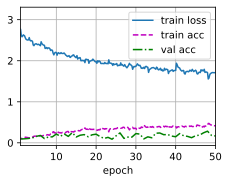

In [ ]:
train(net, train_loader, val_loader, test_loader, num_epochs=50, lr=0.01)

*The graph shows a steady decrease in training loss with moderate training accuracy , but validation accuracy remains low , indicating poor generalization. Among all the attempts we have made this was the best, but as you can see it is not a good model in general.*

# **Evaluate on test set**


The goal of this evaluation is to assess the performance of the best model saved during training. By running the test set through the model, we aim to measure its ability to generalize to unseen data. Specifically, we will analyze the model's predictions, compare them with the ground truth, and gain insights into its classification accuracy. For this purpose, we will print the first 20 predictions, highlighting both the predicted and actual classes for better interpretability.

The function [**load_state_dict**](https://pytorch.org/tutorials/beginner/saving_loading_models.html) is then used to load the parameters into the model architecture (net). It ensures that the saved weights match the layers in the defined architecture. The state_dict in PyTorch is a Python dictionary object that maps each layer in the model to its corresponding parameters (tensors of weights and biases).

In [ ]:
# Path to the saved model
model_path = '/content/FINA_MODEL.pth'

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))  # Load model weights
model.to(device)
model.eval()  # Set the model to evaluation mode

<ipython-input-12-dedcdacddd51>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load model weights


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern

In [ ]:
# Access the original dataset classes
original_dataset = test_loader.dataset.dataset if isinstance(test_loader.dataset, torch.utils.data.Subset) else test_loader.dataset
class_names = original_dataset.classes

# Predictions
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)  # Get the predicted classes
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Print predictions
for i, (pred, true) in enumerate(zip(all_predictions, all_labels)):
    if i >= 20:  # Stop after printing 20 predictions
        break
    print(f"Image {i+1}: Predicted = {class_names[pred]}, True = {class_names[true]}")

Image 1: Predicted = pizza, True = chicken_wings
Image 2: Predicted = club_sandwich, True = ramen
Image 3: Predicted = club_sandwich, True = pizza
Image 4: Predicted = club_sandwich, True = club_sandwich
Image 5: Predicted = club_sandwich, True = beef_tartare
Image 6: Predicted = ice_cream, True = ramen
Image 7: Predicted = pizza, True = pizza
Image 8: Predicted = pizza, True = chicken_wings
Image 9: Predicted = chocolate_cake, True = chocolate_cake
Image 10: Predicted = ice_cream, True = chicken_wings
Image 11: Predicted = pizza, True = beef_tartare
Image 12: Predicted = chocolate_cake, True = chocolate_cake
Image 13: Predicted = chocolate_cake, True = cannoli
Image 14: Predicted = pizza, True = hot_dog
Image 15: Predicted = hot_dog, True = ramen
Image 16: Predicted = club_sandwich, True = beef_tartare
Image 17: Predicted = chocolate_cake, True = ice_cream
Image 18: Predicted = pizza, True = chicken_wings
Image 19: Predicted = pizza, True = bruschetta
Image 20: Predicted = chocolate_c

### **Confusion Matrix**

Accuracy: 22.92%

Classification Report:
                precision    recall  f1-score   support

  beef_tartare       0.00      0.00      0.00        21
    bruschetta       0.00      0.00      0.00        12
  caesar_salad       0.55      0.33      0.41        18
       cannoli       0.00      0.00      0.00        18
 chicken_wings       0.71      0.19      0.30        26
chocolate_cake       0.32      0.58      0.41        26
 club_sandwich       0.18      0.47      0.26        17
     dumplings       0.43      0.18      0.25        17
       hot_dog       0.33      0.04      0.07        25
     ice_cream       0.14      0.08      0.10        26
         pizza       0.10      0.69      0.17        13
         ramen       0.40      0.29      0.33        21

      accuracy                           0.23       240
     macro avg       0.26      0.24      0.19       240
  weighted avg       0.29      0.23      0.20       240



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


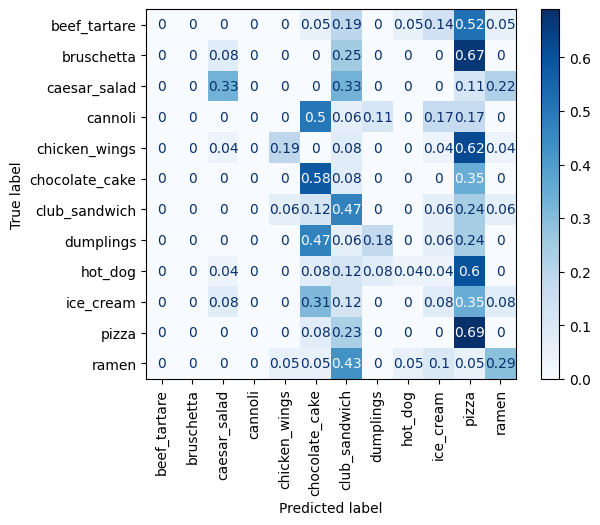

In [ ]:
# Predictions and Ground Truth
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for X, y in test_loader:  # Assuming `test_loader` is already defined
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)  # Get the predicted classes
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert predictions and labels to numpy arrays
Y_pred = np.array(all_predictions)
Y_true = np.array(all_labels)

# Mapping classes
original_dataset = test_loader.dataset.dataset if isinstance(test_loader.dataset, torch.utils.data.Subset) else test_loader.dataset
class_to_idx = original_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Compute metrics
acc = accuracy_score(Y_true, Y_pred)
report = classification_report(Y_true, Y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))])
conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true')
conf_mat = np.round(conf_mat, 2)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_mat, display_labels=[idx_to_class[i] for i in range(len(idx_to_class))])
print(f"Accuracy: {round(acc*100, 2)}%\n")
print(f"Classification Report:\n{report}")
disp.plot(cmap="Blues", xticks_rotation=90)


The confusion matrix highlights that the model performs well on certain classes, such as **"dumplings"** and **"club_sandwich"**, where most predictions align with the true labels. However, it struggles significantly with others, such as **"beef_tartare"** and **"bruschetta"**, where predictions are heavily spread across multiple classes.

Key observations:
- **Misclassifications**: There is notable confusion between visually similar classes like **"beef_tartare"**, **"bruschetta"**, and **"ramen"**.
- **High Accuracy Classes**: Classes like **"dumplings"** and **"club_sandwich"** show clear dominance on the diagonal, indicating strong predictions.
- **Further Attempts**: Given the unsatisfactory results overall, we continued with further attempts, exploring different strategies such as model fine-tuning, enhanced data preprocessing, and augmentation to improve performance.

# **ResNet**

In an attempt to improve prediction accuracy, given the poor performance observed with GoogLeNet, we implemented a ResNet-18, introduced by He et al. in the seminal 2016 paper "Deep Residual Learning for Image Recognition". ResNet’s Residual Block was specifically designed to address the vanishing gradient problem, which we encountered during our analysis of previous architectures.

The Residual Block consists of:

Two convolutional layers followed by batch normalization and a ReLU activation function.
Skip connections, which add the input directly to the output of the convolutions, enabling efficient gradient flow and mitigating vanishing gradients.
A downsample mechanism, which adjusts the spatial dimensions of the input to match the output when required.
Building on this foundation, we introduced an enhanced implementation of ResNet-18 tailored to our specific use case. Below are the key characteristics of our architecture:

Residual Block:
Each block contains two
3
×
3
 convolutional layers, each followed by batch normalization and ReLU activation.
To further regularize the model and reduce overfitting, we added Dropout layers after each convolution, with a configurable dropout rate.
A downsampling mechanism is employed within the skip connection when the input and output dimensions differ, achieved via a
1
×
1
convolution and batch normalization.

ResNet-18 Architecture:
The network begins with an initial convolutional layer (
7
×
7
 kernel, stride 2) followed by batch normalization, ReLU activation, and max pooling.

Four main layers, each comprising multiple Residual Blocks:

- Layer 1: Processes feature maps of 64 channels.
- Layer 2: Upscales to 128 channels with spatial downsampling.
- Layer 3: Further scales to 256 channels.
- Layer 4: Produces 512-channel feature maps.

Global Average Pooling reduces the spatial dimensions to
1
×
1
1×1, preparing the feature maps for the final classifier.

A fully connected layer maps the processed features to the 12 target classes.
Dropout is also applied before the final classification layer for additional regularization.




In [ ]:
mean = [0.5437, 0.4453, 0.3496]
std = [0.2687, 0.2710, 0.2731]

dataset, train_loader, val_loader, test_loader = data_loader(dataset_path = dataset_path,
                                                             batch_size = 64,
                                                             height = 299, width = 299,
                                                             augmentation = True,
                                                             mean = mean, std = std, seed=42)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(p=dropout_rate)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_rate)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)

        out += identity
        out = self.relu(out)
        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=12, dropout_rate=0.0):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.0):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    # Forward method
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, weight_decay=0.0, device=d2l.try_gpu()):

    # Xavier initialization for weights
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('Training on', device)

    net.to(device)  # Move the network to GPU if available
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)

    # Lists to store metrics per epoch
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Initialize metrics accumulator
        metric = d2l.Accumulator(3)  # [Sum of training loss, correct predictions, total samples]
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            # Forward pass and loss calculation
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            timer.stop()

            # Update metrics
            with torch.no_grad():
                metric.add(loss.item() * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])

            # Update animator every few batches
            if (i + 1) % max(1, (num_batches // 5)) == 0 or i == num_batches - 1:
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[2]
                animator.add(epoch + (i + 1) / num_batches,
                             (train_loss, train_acc, None))

        # Save metrics for the epoch
        train_loss = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Evaluate on validation set after each epoch
        val_acc = d2l.evaluate_accuracy_gpu(net, val_iter)
        val_acc_history.append(val_acc)
        animator.add(epoch + 1, (None, None, val_acc))

        print(f"Epoch {epoch + 1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

    # Final evaluation on test set
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    print(f'Final Test Accuracy: {test_acc:.4f}')
    print(f'Training Speed: {metric[2] * num_epochs / timer.sum():.1f} samples/sec on {device}')

    # Save the final model
    torch.save(net.state_dict(), 'ResNet.pth')
    print("Final model saved as 'ResNet.pth'")

    # Return the metrics history
    return train_loss_history, train_acc_history, val_acc_history


Training Progress: 100%|██████████| 50/50 [39:46<00:00, 47.73s/it]

Epoch 50: Train Loss 1.6817, Train Acc 0.4464, Val Acc 0.4250


Final Test Accuracy: 0.4250
Training Speed: 1732.6 samples/sec on cuda:0
Final model saved as 'FINAL_MODEL.pth'


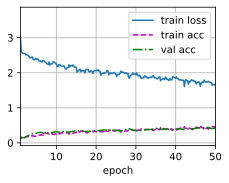

In [ ]:
# Define the ResNet model
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=12, dropout_rate=0.2)  # ResNet-18 with 12 classes

# Hyperparameters
learning_rate = 0.001
num_epochs = 50
weight_decay = 1e-4

# Train the model
train_loss, train_acc, val_acc = train(
    net=model,
    train_iter=train_loader,
    val_iter=val_loader,
    test_iter=test_loader,  # Added test set evaluation
    num_epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay
)



The training loss gradually decreases over the epochs; however, towards the end, the curve flattens, suggesting that the model stops learning effectively from the training data. The training accuracy shows a consistent improvement, as do the validation and test accuracies. However, the final accuracy remains relatively low , 42% and stops increasing after a certain number of epochs. Following the pattern of training and validation accuracies, it seems that the model does not exhibit overfitting. On the contrary, the minimal difference between the two could even indicate underfitting.

# **Conclusion**
We implemented a built-in GoogLeNet model to perform image classification on a dataset of 12 classes of dishes (food). The initial results were suboptimal, primarily due to the vanishing gradient problem. To address this issue, we enhanced the GoogLeNet architecture by integrating batch normalization, replacing the ReLU activation function with LeakyReLU, and incorporating dropout layers to mitigate overfitting. Although these modifications led to improvements, the results remained below acceptable levels.

Therefore, we conducted an experiment using ResNet18, an architecture inherently designed to overcome the vanishing gradient issue through the use of residual connections. The results obtained with ResNet18 were significantly better, although still not excellent.

In conclusion, we believe the primary problem is in the preprocessing of the dataset images, which needs to be more thorough. This could involve discarding low-quality images, noise reduction and implementing precise cropping to focus on relevant features. Additionally, increasing the number of samples per class is likely to improve the model's performance by providing a more representative dataset for training.